# Introduction and Dataset

## Background

Add bg

## Tutorial goals

**Goal 1: Train a semantic segmentation convolutional neural network (CNN) to classify tree species across the PRF using the 2018 Sentinel-2 imagery.**

**Goal 2: Apply the trained CNN for inference to the 2024 Sentinel-2 imagery**  

**Goal 3: Evaluate the species change differences between the two time periods. Discuss and explain changes and differences**

## Data

This tutorial makes use of Sentinel-2 multispectral imagery. See the README or website for more information about the Sentinel-2 dataset.

## References

- [Excellent github repo with many deep learning applications to satellite imagery](https://github.com/satellite-image-deep-learning/techniques)


Add export of unsupervised classified imagery for tutorial

Used this tutorial as a reference:

https://medium.com/@heyamit10/pytorch-segmentation-models-a-practical-guide-5bf973a32e30

Useful crop classification exmaple repo:

https://github.com/Orion-AI-Lab/S4A

In [49]:
import rioxarray as rio
from rasterio.plot import show
import numpy as np
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import rasterio
from rasterio.warp import reproject, Resampling


In [13]:
# Helper functions

def load_and_align(path, ref_crs, ref_transform, ref_shape):
    with rasterio.open(path) as src:
        arr = np.empty(ref_shape, dtype=src.dtypes[0])
        reproject(
            source=src.read(1),
            destination=arr,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=ref_transform,
            dst_crs=ref_crs,
            resampling=Resampling.bilinear
        )
    return arr

def simplify_plt(ax):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

def plot_rgb(rgb, ax, low_perc=1, high_perc=99):

    #find the values to do contrast stretching
    vmin, vmax = np.nanpercentile(rgb, (low_perc, high_perc))

    #ensure values are between 0 and 1
    rgb = np.clip(rgb, vmin, vmax)

    # Visualize the PRF Sentinel-2 imagery
    show(rgb, ax=ax, adjust=True)


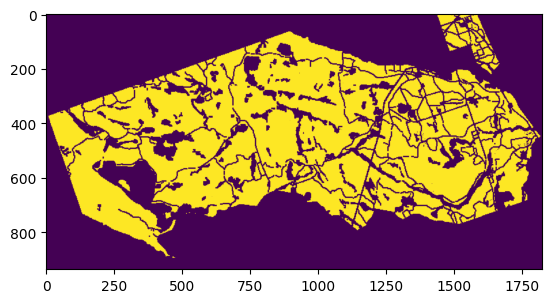

<Axes: >

In [19]:
# Set fpaths

s2_2018_fpath = r'data/petawawa_s2_2018.tif'

als_metrics_fpath = r'data/als_metrics.tif'

sp_ras_fpath = r'data/prf_tree_species_ntems.tif'

prf_boundary_fpath = r'data/boundary.gpkg'

prf_boundary = gpd.read_file(prf_boundary_fpath)

with rasterio.open(s2_2018_fpath) as ref:
    ref_crs = ref.crs
    ref_transform = ref.transform
    ref_shape = (ref.height, ref.width)

    s2_2018 = ref.read()

p95_ras = load_and_align(als_metrics_fpath, ref_crs, ref_transform, ref_shape)

sp_ras = load_and_align(sp_ras_fpath, ref_crs, ref_transform, ref_shape)

# Mask out pixels where p95 is below 1m
forest_mask = p95_ras > 1

forest_mask = forest_mask.astype('uint8')

# Apply forest mask to species raster
sp_ras = sp_ras * forest_mask

show(forest_mask)

In [27]:
# Confirm all rasters have the same shape
print(sp_ras.shape)
print(p95_ras.shape)
print(s2_2018.shape)

(937, 1824)
(937, 1824)
(12, 937, 1824)


In [16]:
# Load species codes to get names from raster
sp_codes_fpath = r'data/ntems_lead_sp_codes.csv'

sp_code_df = (pd.read_csv(sp_codes_fpath)
              .rename(columns={'Class': 'sp_code',
                               'Common name': 'species'})
              )

# Check sp frequency
sp_counts = np.unique(sp_ras, return_counts=True)

sp_df = pd.DataFrame({'species': sp_counts[0], 
                            'count': sp_counts[1]})

sp_df['perc'] = round(sp_df['count'] / sp_df['count'].sum() * 100, 1)

sp_df = (sp_df
 .sort_values('count', ascending=False)
 .reset_index(drop=True)
 .rename(columns={'species': 'sp_code'})
 .merge(sp_code_df, on='sp_code', how='inner')
 )

sp_df

,sp_code,count,perc,NFI code,species,Scientific name
0,0,1014764,59.4,Non treed,Non treed,Non treed
1,26,557709,32.6,PINU.STR,Eastern white pine,Pinus strobus
2,6,63189,3.7,ACER.SAH,Sugar maple,Acer saccharum
3,18,25037,1.5,PICE.MAR,Black spruce,Picea mariana
4,25,10148,0.6,PINU.RES,Red pine,Pinus resinosa
5,15,9146,0.5,PICE.ABI,Norway spruce,Picea abies
6,17,8515,0.5,PICE.GLA,White spruce,Picea glauca
7,22,8493,0.5,PINU.BAN,Jack pine,Pinus banksiana
8,7,6848,0.4,ALNU.INC,Gray alder,Alnus incana
9,29,1280,0.1,POPU.TRE,Trembling aspen,Populus tremuloides


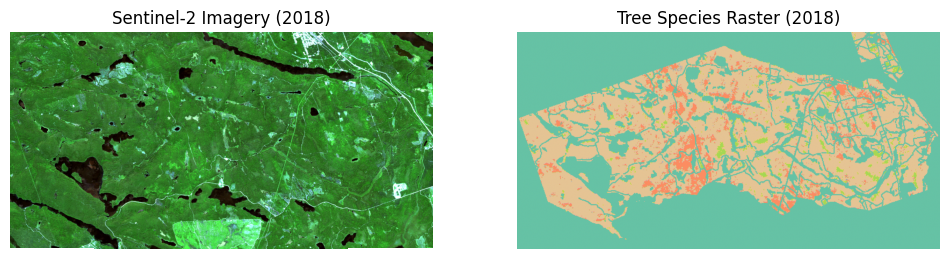

In [18]:
# Make side by side plots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot the clipped Sentinel-2 imagery
plot_rgb(s2_2018[1:4], ax=ax[0])
ax[0].set_title('Sentinel-2 Imagery (2018)')

show(sp_ras, ax=ax[1], cmap='Set2')
ax[1].set_title('Tree Species Raster (2018)')

for a in ax:
    simplify_plt(a)

In [ ]:
# Set the number of species classes
N_CLASSES = sp_df.shape[1]

N_BANDS = s2_2018.shape[0]


12

In [51]:
'''
Implementation of the model proposed in:
- Olaf Ronneberger, , Philipp Fischer, and Thomas Brox. "U-Net: Convolutional
Networks for Biomedical Image Segmentation." (2015).

Code adopted from:
https://github.com/PyTorchLightning/lightning-bolts/blob/master/pl_bolts/models/vision/unet.py
'''

import os

import numpy as np
from tqdm import tqdm
import copy
from pathlib import Path
import pickle

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import lr_scheduler
import torch.optim as optim
import pytorch_lightning as pl

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns


def get_last_model_checkpoint(path):
    '''
    Browses through the given path and finds the last saved checkpoint of a
    model.

    Parameters
    ----------
    path: str or Path
        The path to search.

    Returns
    -------
    (Path, Path, int): the path of the last model checkpoint file, the path of the
    last optimizer checkpoint file and the corresponding epoch.
    '''
    model_chkp = [c for c in Path(path).glob('model_state_dict_*')]
    optimizer_chkp = [c for c in Path(path).glob('optimizer_state_dict_*')]
    model_chkp_per_epoch = {int(c.name.split('.')[0].split('_')[-1]): c for c in model_chkp}
    optimizer_chkp_per_epoch = {int(c.name.split('.')[0].split('_')[-1]): c for c in optimizer_chkp}

    last_model_epoch = sorted(model_chkp_per_epoch.keys())[-1]
    last_optimizer_epoch = sorted(optimizer_chkp_per_epoch.keys())[-1]

    assert last_model_epoch == last_optimizer_epoch, 'Error: Could not resume training. Optimizer or model checkpoint missing.'

    return model_chkp_per_epoch[last_model_epoch], optimizer_chkp_per_epoch[last_model_epoch], last_model_epoch


class DoubleConv(nn.Module):
    """[ Conv2d => BatchNorm (optional) => ReLU ] x 2."""

    def __init__(self, in_ch: int, out_ch: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)


class Down(nn.Module):
    """Downscale with MaxPool => DoubleConvolution block."""

    def __init__(self, in_ch: int, out_ch: int):
        super().__init__()
        self.net = nn.Sequential(nn.MaxPool2d(kernel_size=2, stride=2), DoubleConv(in_ch, out_ch))

    def forward(self, x):
        return self.net(x)


class Up(nn.Module):
    """Upsampling (by either bilinear interpolation or transpose convolutions) followed by concatenation of feature
    map from contracting path, followed by DoubleConv."""

    def __init__(self, in_ch: int, out_ch: int, bilinear: bool = False):
        super().__init__()
        self.upsample = None
        if bilinear:
            self.upsample = nn.Sequential(
                nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),
                nn.Conv2d(in_ch, in_ch // 2, kernel_size=1),
            )
        else:
            self.upsample = nn.ConvTranspose2d(in_ch, in_ch // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)

        # Pad x1 to the size of x2
        diff_h = x2.shape[2] - x1.shape[2]
        diff_w = x2.shape[3] - x1.shape[3]

        x1 = F.pad(x1, [diff_w // 2, diff_w - diff_w // 2, diff_h // 2, diff_h - diff_h // 2])

        # Concatenate along the channels axis
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class UNet(pl.LightningModule):
    def __init__(self, run_path, linear_encoder, learning_rate=1e-3, parcel_loss=False,
                 class_weights=None, crop_encoding=None, checkpoint_epoch=None,
                 num_layers=3):
        '''
        Parameters:
        -----------
        run_path: str or Path
            The path to export results into.
        linear_encoder: dict
            A dictionary mapping the true labels to the given labels.
            True labels = the labels in the mappings file.
            Given labels = labels ranging from 0 to len(true labels), which the
            true labels have been converted into.
        learning_rate: float, default 1e-3
            The initial learning rate.
        parcel_loss: boolean, default False
            If True, then a custom loss function is used which takes into account
            only the pixels of the parcels. If False, then all image pixels are
            used in the loss function.
        class_weights: dict, default None
            Weights per class to use in the loss function.
        crop_encoding: dict, default None
            A dictionary mapping class ids to class names.
        checkpoint_epoch: int, default None
            The epoch loaded for testing.
        num_layers: int, default 3
            The number of layers to use in each path.
        '''
        if num_layers < 1:
            raise ValueError(f"num_layers = {num_layers}, expected: num_layers > 0")

        self.num_layers = num_layers

        super(UNet, self).__init__()

        self.linear_encoder = linear_encoder
        self.parcel_loss = parcel_loss

        self.epoch_train_losses = []
        self.epoch_valid_losses = []
        self.avg_train_losses = []
        self.avg_val_losses = []
        self.best_loss = None

        num_discrete_labels = len(set(linear_encoder.values()))
        self.confusion_matrix = torch.zeros([num_discrete_labels, num_discrete_labels])

        self.class_weights = class_weights
        self.checkpoint_epoch = checkpoint_epoch

        if class_weights is not None:
            class_weights_tensor = torch.tensor([class_weights[k] for k in sorted(class_weights.keys())]).cuda()

            if self.parcel_loss:
                self.lossfunction = nn.NLLLoss(ignore_index=0, weight=class_weights_tensor, reduction='sum')
            else:
                self.lossfunction = nn.NLLLoss(ignore_index=0, weight=class_weights_tensor)
        else:
            if self.parcel_loss:
                self.lossfunction = nn.NLLLoss(ignore_index=0, reduction='sum')
            else:
                self.lossfunction = nn.NLLLoss(ignore_index=0)

        self.crop_encoding = crop_encoding

        self.run_path = Path(run_path)

        input_channels = 4 * 6   # bands * time steps

        # Encoder
        # -------
        layers = [DoubleConv(input_channels, 64)]

        feats = 64
        for _ in range(num_layers - 1):
            layers.append(Down(feats, feats * 2))
            feats *= 2

        # Dencoder
        # --------
        for _ in range(num_layers - 1):
            layers.append(Up(feats, feats // 2, False))
            feats //= 2

        layers.append(nn.Conv2d(feats, num_discrete_labels, kernel_size=1))
        layers.append(nn.LogSoftmax(dim=1))

        self.layers = nn.ModuleList(layers)

        # Hyperparameters
        self.learning_rate = learning_rate
        self.save_hyperparameters()


    def forward(self, x):
        xi = [self.layers[0](x)]

        # Down path
        for layer in self.layers[1:self.num_layers]:
            xi.append(layer(xi[-1]))

        # Up path
        for i, layer in enumerate(self.layers[self.num_layers:-2]):
            xi[-1] = layer(xi[-1], xi[-2-i])

        xi[-1] = self.layers[-2](xi[-1])

        # Softmax
        return self.layers[-1](xi[-1])


    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        pla_lr_scheduler = {
            'scheduler': lr_scheduler.ReduceLROnPlateau(optimizer,
                                                        factor=0.5,
                                                        patience=4,
                                                        verbose=True),
            'monitor': 'val_loss'
        }
        return [optimizer], [pla_lr_scheduler]


    def training_step(self, batch, batch_idx):
        inputs = batch['medians']  # (B, T, C, H, W)

        label = batch['labels']  # (B, H, W)
        label = label.to(torch.long)

        # Concatenate time series along channels dimension
        b, t, c, h, w = inputs.size()
        inputs = inputs.view(b, -1, h, w)   # (B, T * C, H, W)

        pred = self(inputs)  # (B, K, H, W)

        if self.parcel_loss:
            parcels = batch['parcels']  # (B, H, W)
            parcels_K = parcels[:, None, :, :].repeat(1, pred.size(1), 1, 1)  # (B, K, H, W)

            # Note: a new masked array must be created in order to avoid inplace
            # operations on the label/pred variables. Otherwise the optimizer
            # will throw an error because it requires the variables to be unchanged
            # for gradient computation

            mask = (parcels) & (label != 0)
            mask_K = (parcels_K) & (label[:, None, :, :].repeat(1, pred.size(1), 1, 1) != 0)

            label_masked = label.clone()
            label_masked[~mask] = 0

            pred_masked = pred.clone()
            pred_masked[~mask_K] = 0

            label = label_masked.clone()
            pred = pred_masked.clone()

            loss = self.lossfunction(pred, label)

            loss = loss / parcels.sum()
        else:
            loss = self.lossfunction(pred, label)

        # Compute total loss for current batch
        loss_aver = loss.item() * inputs.shape[0]

        self.epoch_train_losses.append(loss_aver)

        # torch.nn.utils.clip_grad_value_(self.parameters(), clip_value=10.0)

        return {'loss': loss}


    def validation_step(self, batch, batch_idx):
        inputs = batch['medians']  # (B, T, C, H, W)

        label = batch['labels']  # (B, H, W)
        label = label.to(torch.long)

        # Concatenate time series along channels dimension
        b, t, c, h, w = inputs.size()
        inputs = inputs.view(b, -1, h, w)   # (B, T * C, H, W)

        pred = self(inputs)  # (B, K, H, W)

        if self.parcel_loss:
            parcels = batch['parcels']  # (B, H, W)
            parcels_K = parcels[:, None, :, :].repeat(1, pred.size(1), 1, 1)  # (B, K, H, W)

            # Note: a new masked array must be created in order to avoid inplace
            # operations on the label/pred variables. Otherwise the optimizer
            # will throw an error because it requires the variables to be unchanged
            # for gradient computation

            mask = (parcels) & (label != 0)
            mask_K = (parcels_K) & (label[:, None, :, :].repeat(1, pred.size(1), 1, 1) != 0)

            label_masked = label.clone()
            label_masked[~mask] = 0

            pred_masked = pred.clone()
            pred_masked[~mask_K] = 0

            label = label_masked.clone()
            pred = pred_masked.clone()

            loss = self.lossfunction(pred, label)

            loss = loss / parcels.sum()
        else:
            loss = self.lossfunction(pred, label)

        # Compute total loss for current batch
        loss_aver = loss.item() * inputs.shape[0]

        self.epoch_valid_losses.append(loss_aver)

        return {'val_loss': loss}


    def test_step(self, batch, batch_idx):
        inputs = batch['medians']  # (B, T, C, H, W)

        label = batch['labels'].to(torch.long)  # (B, H, W)

        # Concatenate time series along channels dimension
        b, t, c, h, w = inputs.size()
        inputs = inputs.view(b, -1, h, w)   # (B, T * C, H, W)

        pred = self(inputs).to(torch.long)  # (B, K, H, W)

        # Reverse the logarithm of the LogSoftmax activation
        pred = torch.exp(pred)

        # Clip predictions larger than the maximum possible label
        pred = torch.clamp(pred, 0, max(self.linear_encoder.values()))

        if self.parcel_loss:
            parcels = batch['parcels']  # (B, H, W)
            parcels_K = parcels[:, None, :, :].repeat(1, pred.size(1), 1, 1)  # (B, K, H, W)

            mask = (parcels) & (label != 0)
            mask_K = (parcels_K) & (label[:, None, :, :].repeat(1, pred.size(1), 1, 1) != 0)
            label[~mask] = 0
            pred[~mask_K] = 0

            pred_sparse = pred.argmax(axis=1)

            label = label.flatten()
            pred = pred_sparse.flatten()

            # Discretize predictions
            #bins = np.arange(-0.5, sorted(list(self.linear_encoder.values()))[-1] + 0.5, 1)
            #bins_idx = torch.bucketize(pred, torch.tensor(bins).cuda())
            #pred_disc = bins_idx - 1

        for i in range(label.shape[0]):
            self.confusion_matrix[label[i], pred[i]] += 1

        return


    def training_epoch_end(self, outputs):
        # Calculate average loss over an epoch
        train_loss = np.nanmean(self.epoch_train_losses)
        self.avg_train_losses.append(train_loss)

        with open(self.run_path / "avg_train_losses.txt", 'a') as f:
            f.write(f'{self.current_epoch}: {train_loss}\n')

        with open(self.run_path / 'lrs.txt', 'a') as f:
            f.write(f'{self.current_epoch}: {self.learning_rate}\n')

        self.log('train_loss', train_loss, prog_bar=True)

        # Clear list to track next epoch
        self.epoch_train_losses = []


    def validation_epoch_end(self, outputs):
        # Calculate average loss over an epoch
        valid_loss = np.nanmean(self.epoch_valid_losses)
        self.avg_val_losses.append(valid_loss)

        with open(self.run_path / "avg_val_losses.txt", 'a') as f:
            f.write(f'{self.current_epoch}: {valid_loss}\n')

        self.log('val_loss', valid_loss, prog_bar=True)

        # Clear list to track next epoch
        self.epoch_valid_losses = []


    def test_epoch_end(self, outputs):
        self.confusion_matrix = self.confusion_matrix.cpu().detach().numpy()

        self.confusion_matrix = self.confusion_matrix[1:, 1:]  # Drop zero label

        # Calculate metrics and confusion matrix
        fp = self.confusion_matrix.sum(axis=0) - np.diag(self.confusion_matrix)
        fn = self.confusion_matrix.sum(axis=1) - np.diag(self.confusion_matrix)
        tp = np.diag(self.confusion_matrix)
        tn = self.confusion_matrix.sum() - (fp + fn + tp)

        # Sensitivity, hit rate, recall, or true positive rate
        tpr = tp / (tp + fn)
        # Specificity or true negative rate
        tnr = tn / (tn + fp)
        # Precision or positive predictive value
        ppv = tp / (tp + fp)
        # Negative predictive value
        npv = tn / (tn + fn)
        # Fall out or false positive rate
        fpr = fp / (fp + tn)
        # False negative rate
        fnr = fn / (tp + fn)
        # False discovery rate
        fdr = fp / (tp + fp)
        # F1-score
        f1 = (2 * ppv * tpr) / (ppv + tpr)

        # Overall accuracy
        accuracy = (tp + tn) / (tp + fp + fn + tn)

        # Export metrics in text file
        metrics_file = self.run_path / f"evaluation_metrics_epoch{self.checkpoint_epoch}.csv"

        # Delete file if present
        metrics_file.unlink(missing_ok=True)

        with open(metrics_file, "a") as f:
            row = 'Class'
            for k in sorted(self.linear_encoder.keys()):
                if k == 0: continue
                row += f',{k} ({self.crop_encoding[k]})'
            f.write(row + '\n')

            row = 'tn'
            for i in tn:
                row += f',{i}'
            f.write(row + '\n')

            row = 'tp'
            for i in tp:
                row += f',{i}'
            f.write(row + '\n')

            row = 'fn'
            for i in fn:
                row += f',{i}'
            f.write(row + '\n')

            row = 'fp'
            for i in fp:
                row += f',{i}'
            f.write(row + '\n')

            row = "specificity"
            for i in tnr:
                row += f',{i:.4f}'
            f.write(row + '\n')

            row = "precision"
            for i in ppv:
                row += f',{i:.4f}'
            f.write(row + '\n')

            row = "recall"
            for i in tpr:
                row += f',{i:.4f}'
            f.write(row + '\n')

            row = "accuracy"
            for i in accuracy:
                row += f',{i:.4f}'
            f.write(row + '\n')

            row = "f1"
            for i in f1:
                row += f',{i:.4f}'
            f.write(row + '\n')

            row = 'weighted macro-f1'
            class_samples = self.confusion_matrix.sum(axis=1)
            weighted_f1 = ((f1 * class_samples) / class_samples.sum()).sum()
            f.write(row + f',{weighted_f1:.4f}\n')

        # Normalize each row of the confusion matrix because class imbalance is
        # high and visualization is difficult
        row_mins = self.confusion_matrix.min(axis=1)
        row_maxs = self.confusion_matrix.max(axis=1)
        cm_norm = (self.confusion_matrix - row_mins[:, None]) / (row_maxs[:, None] - row_mins[:, None])

        # Export Confusion Matrix

        # Replace invalid values with 0
        self.confusion_matrix = np.nan_to_num(self.confusion_matrix, nan=0.0, posinf=0.0, neginf=0.0)

        # Create plot
        fig, ax = plt.subplots(1, 1, figsize=(7, 7))
        sns.heatmap(self.confusion_matrix, annot=False, ax=ax, cmap="Blues", fmt="g")

        # Labels, title and ticks
        label_font = {'size': '18'}
        ax.set_xlabel('Predicted labels', fontdict=label_font, labelpad=10)
        ax.set_ylabel('Observed labels', fontdict=label_font, labelpad=10)

        ax.set_xticks(list(np.arange(0.5, len(self.linear_encoder.keys()) - 1 + 0.5)))
        ax.set_yticks(list(np.arange(0.5, len(self.linear_encoder.keys()) - 1 + 0.5)))

        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')

        ax.set_xticklabels([f'{self.crop_encoding[k]} ({k})' for k in sorted(self.linear_encoder.keys()) if k != 0], fontsize=8, rotation='vertical')
        ax.set_yticklabels([f'{self.crop_encoding[k]} ({k})' for k in sorted(self.linear_encoder.keys()) if k != 0], fontsize=8, rotation='horizontal')

        ax.tick_params(axis='both', which='major')

        title_font = {'size': '21'}
        ax.set_title('Confusion Matrix', fontdict=title_font)

        for i in range(len(self.linear_encoder.keys()) - 1):
            ax.add_patch(Rectangle((i, i), 1, 1, fill=False, edgecolor='red', lw=2))

        plt.savefig(self.run_path / f'confusion_matrix_epoch{self.checkpoint_epoch}.png', dpi=fig.dpi, bbox_inches='tight', pad_inches=0.5)

        np.save(self.run_path / f'cm_epoch{self.checkpoint_epoch}.npy', self.confusion_matrix)


        # Export normalized Confusion Matrix

        # Replace invalid values with 0
        cm_norm = np.nan_to_num(cm_norm, nan=0.0, posinf=0.0, neginf=0.0)

        # Create plot
        fig, ax = plt.subplots(1, 1, figsize=(7, 7))
        sns.heatmap(cm_norm, annot=False, ax=ax, cmap="Blues", fmt="g")

        # Labels, title and ticks
        label_font = {'size': '18'}
        ax.set_xlabel('Predicted labels', fontdict=label_font, labelpad=10)
        ax.set_ylabel('Observed labels', fontdict=label_font, labelpad=10)

        ax.set_xticks(list(np.arange(0.5, len(self.linear_encoder.keys()) - 1 + 0.5)))
        ax.set_yticks(list(np.arange(0.5, len(self.linear_encoder.keys()) - 1 + 0.5)))

        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')

        ax.set_xticklabels([f'{self.crop_encoding[k]} ({k})' for k in sorted(self.linear_encoder.keys()) if k != 0], fontsize=8, rotation='vertical')
        ax.set_yticklabels([f'{self.crop_encoding[k]} ({k})' for k in sorted(self.linear_encoder.keys()) if k != 0], fontsize=8, rotation='horizontal')

        ax.tick_params(axis='both', which='major')

        title_font = {'size': '21'}
        ax.set_title('Confusion Matrix', fontdict=title_font)

        for i in range(len(self.linear_encoder.keys()) - 1):
            ax.add_patch(Rectangle((i, i), 1, 1, fill=False, edgecolor='red', lw=2))

        plt.savefig(self.run_path / f'confusion_matrix_norm_epoch{self.checkpoint_epoch}.png', dpi=fig.dpi, bbox_inches='tight', pad_inches=0.5)

        np.save(self.run_path / f'cm_norm_epoch{self.checkpoint_epoch}.npy', self.confusion_matrix)
        pickle.dump(self.linear_encoder, open(self.run_path / f'linear_encoder_epoch{self.checkpoint_epoch}.pkl', 'wb'))